# Plotting fit results from Mie model 

In [34]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np

## Plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


In [233]:
## Parameter setting needs to be in cell following mpl import for some reason 
## https://github.com/jupyter/notebook/issues/3385
##
## Default parameters inspired by 
## http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
#     'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 10,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001,
    'axes.labelpad':5,
}
mpl.rcParams.update(params)
## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get physical constants from Scipy
import scipy.constants as con

## For fitting
import scipy.optimize as opt

## For matlab loading
import scipy.io as sio

## Load custom package modules
from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import diffraction_int as diffi
from misloc_mispol_package.optics import fibonacci as fib
from misloc_mispol_package.parameterize import spec_fit as spit

## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

m_per_nm = fit.m_per_nm

eps_b = 1.778 ## Water
cm_per_nm = 1E-7

hres_obs_pts = diffi.observation_points(
    -480*m_per_nm, 480*m_per_nm, -480*m_per_nm, 480*m_per_nm, 201)

In [4]:
def label_offset(ax, axis="y"):
    if axis == "y":
        fmt = ax.yaxis.get_major_formatter()
        ax.yaxis.offsetText.set_visible(False)
        set_label = ax.set_ylabel
        label = ax.get_ylabel()

    elif axis == "x":
        fmt = ax.xaxis.get_major_formatter()
        ax.xaxis.offsetText.set_visible(False)
        set_label = ax.set_xlabel
        label = ax.get_xlabel()

    def update_label(event_axes):
        offset = fmt.get_offset()
        if offset == '':
            set_label("{}".format(label))
        else:
            set_label("{} ({})".format(label, offset))
        return

    ax.callbacks.connect("ylim_changed", update_label)
    ax.callbacks.connect("xlim_changed", update_label)
    ax.figure.canvas.draw()
    update_label(None)
    return


In [5]:
path_to_spec = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'MATLAB',
    'disk_simulations'
    )

sphere_spec = sio.loadmat(os.path.join(
    path_to_spec,
    'DrudeSphere80nm_inWater.mat'
    ))
## Convert to eV and plot spectra 
hw = 1240/sphere_spec['enei'][0]
spec = sphere_spec['sca']

# plt.figure(figsize=(2,1.5), dpi=150)
# for i, spectrum in enumerate(spec.T):
#     plt.plot(hw, spectrum)
# plt.xlabel('eV')
# plt.ylabel('$\mathrm{nm}^2$')
# plt.title('Drude Sphere Scattering')

array([9.82335326e+00, 9.06705560e+00, 3.34860149e-02, 4.12504947e+01])

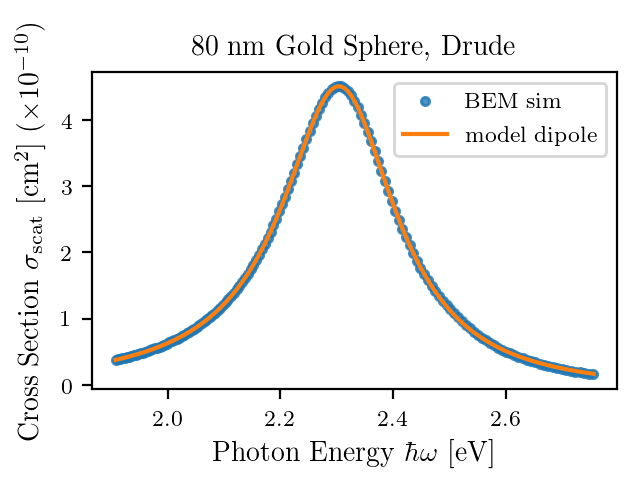

In [6]:
params0=np.array([
    13.99604932, 10.05123876,  0.28443696, 36.1993746,
#     .5,
#     4,
#     2,
# #     0.95
    ])

eneis = 1240/sphere_spec['enei'][0, :]
spec = sphere_spec['sca'].T[0, :]

high_enei_cutoff = 3

args=[
    eneis[eneis<high_enei_cutoff],
    spec[eneis<high_enei_cutoff]
    ]

# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    spit.sphere_Mie_cost_fun, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     bounds=(
#         [5, 5, 0.01, 39,],
#         [50, 20, 0.09, 41,]
#         )
#     bounds=(
#         [  0, 0,  0.09, 40, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, 0.0901, np.inf,  np.inf,  4,  2.1,]
#     )
#     bounds=(
#         [  0, 0,  0.09, 30, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, np.inf, np.inf,  np.inf,  4,  2.1,]
#         )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = spit.sphere_fit_fun(
    eneis, 
    *result['x'],
    model_cross_section=cp.sigma_scat_Mie_sphere
    )
norm_fit_result = fit_result/fit_result.max()

# high_damp_result = spit.sphere(args[0], *higher_damp)

data = spec*(spit.cm_per_nm**2)
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(eneis, data, label='BEM sim', ls=' ', marker='.',
#          markersize=2,
         alpha=.8
        )
plt.plot(eneis, fit_result, label='model dipole', ls='-')


# fit_gauss = (
#     result['x'][4]
#     *
#     np.exp(
#         -(result['x'][5]-eneis)**2.
#         /
#         result['x'][6]**2.
#         )*1E-10
#     )
# plt.plot(eneis, fit_gauss,label='phenomenological gaussian', ls='-')


plt.xlabel(r'Photon Energy $\hbar\omega$ [eV]')
plt.ylabel(r'Cross Section $\sigma_\mathrm{scat}$ [cm$^2$]')
plt.title(r'80 nm Gold Sphere, Drude')
plt.legend()

ax = plt.gca()
label_offset(ax, "y")
result['x']

In [8]:
locations, angles = fit.fixed_ori_mol_placement(
    mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude_Mie',
    simulation_file_name='SphereDrude_NoSub_dipDrive_E',
    sphere_model='Mie')
sim_inst.trial_images = sim_inst.calculate_BEM_fields()

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


In [9]:
fit_inst = fit.FitModelToData(
    sim_inst.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude_Mie',
    sphere_model='Mie',
    )
the_fit = fit_inst.fit_model_to_image_data(
    check_ini=True)


 initial guess for molecule 0 location: (-0.05956453895397893,12.22642284825891)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.05956453895397893 
 ini_y,  12.22642284825891 
 self.quel_a,  51.2504947 
 self.quel_c,  51.2504947 

In quenching zone? True
Params modified, OG params: (-0.05956453895397893, 12.22642284825891, array([0.70805642]))
but now they are: (-0.24967857724874126, 51.24988651307231, array([0.70805642]))

 initial guess for molecule 1 location: (-0.002218041915983311,98.73890736694932)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.002218041915983311 
 ini_y,  98.73890736694932 
 self.quel_a,  51.2504947 
 self.quel_c,  51.2504947 

In quenching zone? False

 initial guess for molecule 2 location: (-0.0004509271978574095,139.1403183498142)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.0004509271978574095 
 ini_y,  139.1403183498142 
 self.quel_a,  51.2504947 
 self.quel_c,  51.2504947 

In quenc

Calculating Gaussian centroid with BEM_images


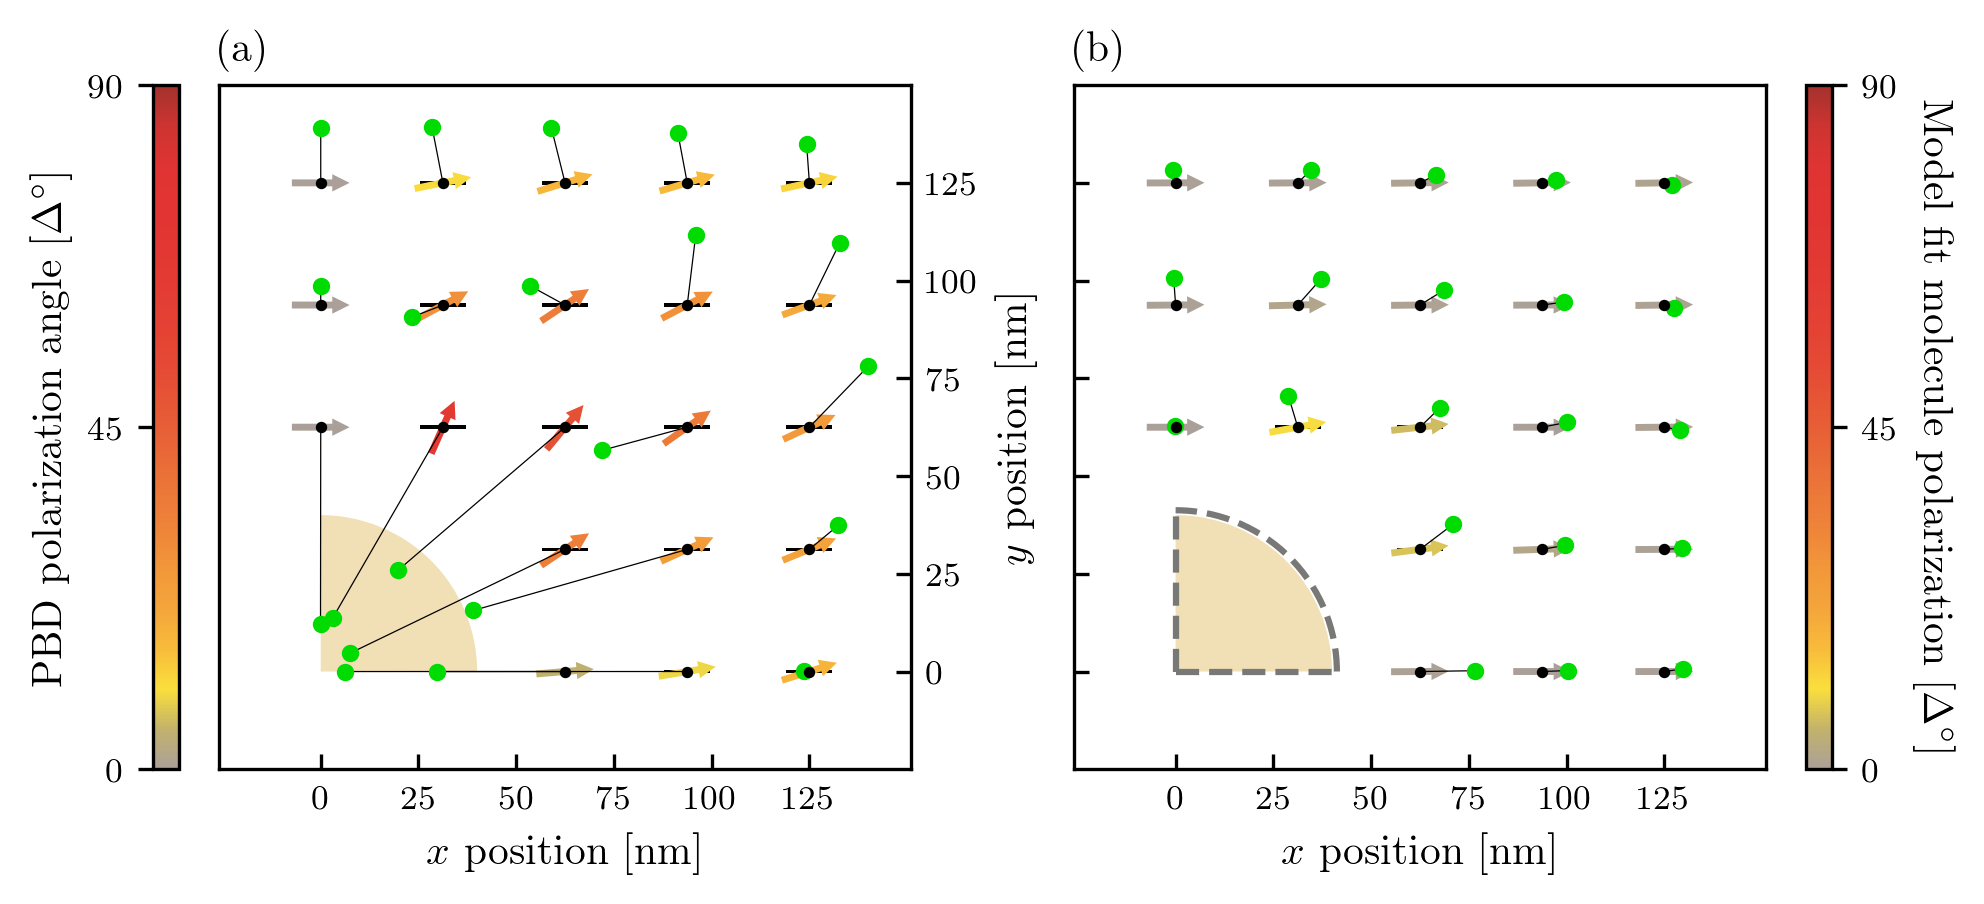

In [10]:
axs, fig5 = bem.fig5(sim_inst, fit_inst, draw_quadrant=True)

In [27]:
sim_inst.__dict__.keys()

dict_keys(['exclude_interference', 'mol_locations', 'mol_angles', 'rod_angle', 'parameters', 'drive_energy_eV', 'eps_inf', 'omega_plasma', 'gamma_drude', 'a_long_meters', 'a_short_meters', 'true_a_un_me', 'is_sphere', 'true_a_de_me', 'eps_b', 'fluo_quench_range', 'fluo_ext_coef', 'fluo_mass_hbar_gamma', 'fluo_nr_hbar_gamma', 'drive_amp', 'alpha0_diag_dyad', 'sphere_model', 'alpha1_diag_dyad', 'el_c', 'el_a', 'sensor_size', 'obs_points', 'drive_I', 'quel_a', 'quel_c', 'input_x_mol', 'input_y_mol', 'pt_is_in_ellip', 'mol_E', 'plas_E', 'p0_unc_E', 'p0', 'p1', 'anal_images', 'default_plot_limits', 'simulation_type', 'simulation_file_name', 'magnification', 'numerical_aperture', 'max_theta', 'lens_points', 'obj_f', 'tube_f', 'BEM_images', 'bem_E', 'matlab_cart_points_on_sph', 'BEM_scattered_E', 'trial_images', 'appar_cents', 'x_gau_cen', 'y_gau_cen', 'angles', 'Px_per_drive_I', 'Py_per_drive_I', 'mispol_angle'])

In [135]:
fit_inst.__dict__.keys()

dict_keys(['mol_angles', 'rod_angle', 'image_data', 'ini_guess', 'parameters', 'drive_energy_eV', 'eps_inf', 'omega_plasma', 'gamma_drude', 'a_long_meters', 'a_short_meters', 'true_a_un_me', 'is_sphere', 'true_a_de_me', 'eps_b', 'fluo_quench_range', 'fluo_ext_coef', 'fluo_mass_hbar_gamma', 'fluo_nr_hbar_gamma', 'drive_amp', 'alpha0_diag_dyad', 'sphere_model', 'alpha1_diag_dyad', 'el_c', 'el_a', 'sensor_size', 'obs_points', 'drive_I', 'quel_a', 'quel_c', 'model_fit_results', 'x_gau_cen', 'y_gau_cen'])

In [136]:
fit_inst.model_fit_results

array([[-7.26590693e-02,  6.27264400e+01,  1.84873628e-03],
       [-5.02277977e-01,  1.00710026e+02,  9.30727721e-03],
       [-5.81947844e-01,  1.28300167e+02,  4.03219093e-03],
       [ 2.88304423e+01,  7.05576411e+01,  1.80656119e-01],
       [ 3.70785934e+01,  1.00303533e+02,  2.64729917e-02],
       [ 3.46800486e+01,  1.28330093e+02,  7.38886422e-03],
       [ 7.65608347e+01,  2.02122343e-01,  8.34429994e-03],
       [ 7.10127850e+01,  3.76719105e+01,  1.29700958e-01],
       [ 6.75989946e+01,  6.74456622e+01,  1.11610980e-01],
       [ 6.86532947e+01,  9.75516868e+01,  1.10615559e-02],
       [ 6.66712254e+01,  1.27068467e+02,  1.34715180e-02],
       [ 1.00336250e+02,  2.41606144e-01,  8.77445220e-04],
       [ 9.96688409e+01,  3.22863183e+01,  3.33930766e-02],
       [ 1.00081636e+02,  6.37288217e+01,  2.59147213e-03],
       [ 9.92592051e+01,  9.44996726e+01,  4.26914023e-03],
       [ 9.73197831e+01,  1.25783537e+02,  1.32494609e-02],
       [ 1.29848645e+02,  6.72411124e-01

In [137]:
fit_inst.raveled_model_of_params(fit_inst.model_fit_results[4])

array([7.53441247e-22, 8.97841010e-22, 1.00629609e-21, ...,
       6.11018497e-22, 7.42899088e-22, 8.93050410e-22])

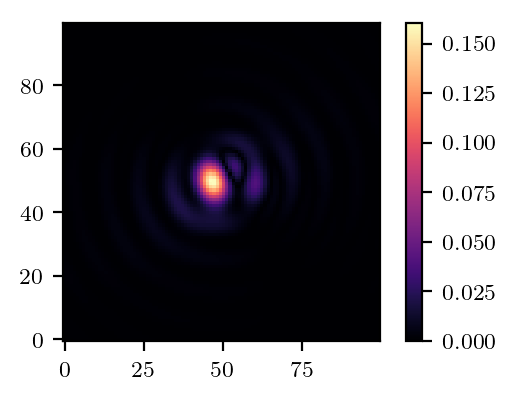

In [142]:
sim_img_4 = sim_inst.trial_images[4].reshape((100,100))
normed_sim_img_4 = sim_img_4/np.max(sim_img_4)
ana_img_4 = sim_inst.anal_images[4].reshape((100,100))
normed_ana_img_4 = ana_img_4/np.max(ana_img_4)
fit_img_4 = fit_inst.raveled_model_of_params(fit_inst.model_fit_results[4]).reshape((100,100))
normed_fit_img_4 = fit_img_4/np.max(fit_img_4)

plt.imshow(np.abs(normed_sim_img_4-normed_ana_img_4))
plt.colorbar()

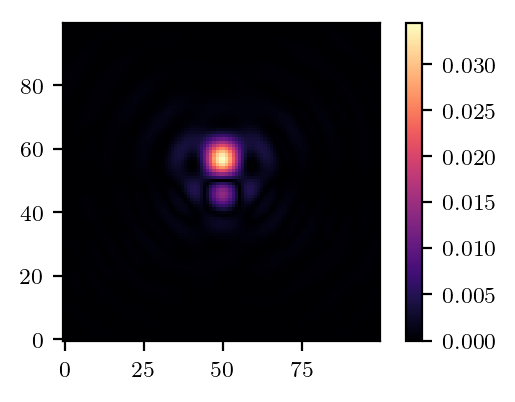

In [165]:
sim_img_6 = sim_inst.trial_images[6].reshape((100,100))
normed_sim_img_6 = sim_img_6/np.max(sim_img_6)
ana_img_6 = sim_inst.anal_images[6].reshape((100,100))
normed_ana_img_6 = ana_img_6/np.max(ana_img_6)
fit_img_6 = fit_inst.raveled_model_of_params(fit_inst.model_fit_results[6]).reshape((100,100))
normed_fit_img_6 = fit_img_6/np.max(fit_img_6)

plt.imshow(np.abs(normed_sim_img_6-normed_ana_img_6))
plt.colorbar()

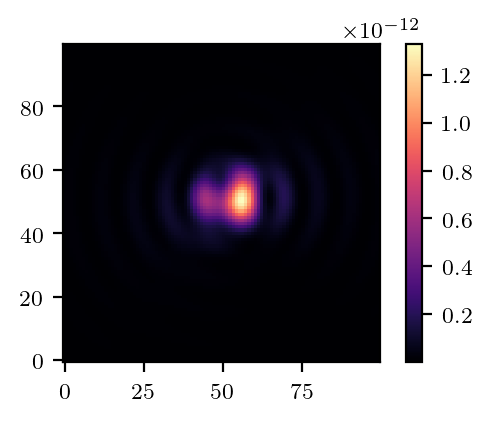

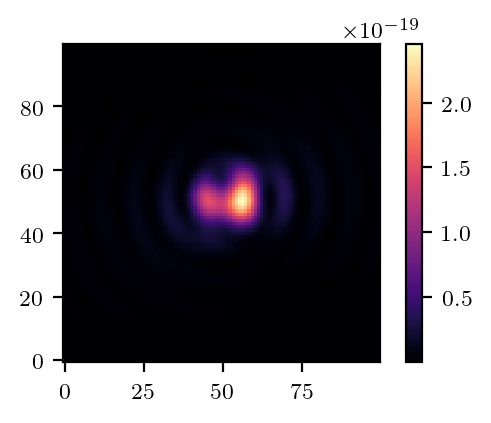

In [22]:
plt.imshow(np.abs(sim_img_4))
plt.colorbar()
plt.figure()
plt.imshow(np.abs(ana_img_4))
plt.colorbar()

In [32]:
sim_inst.obs_points[1].shape

(100, 100)

In [196]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter, StrMethodFormatter

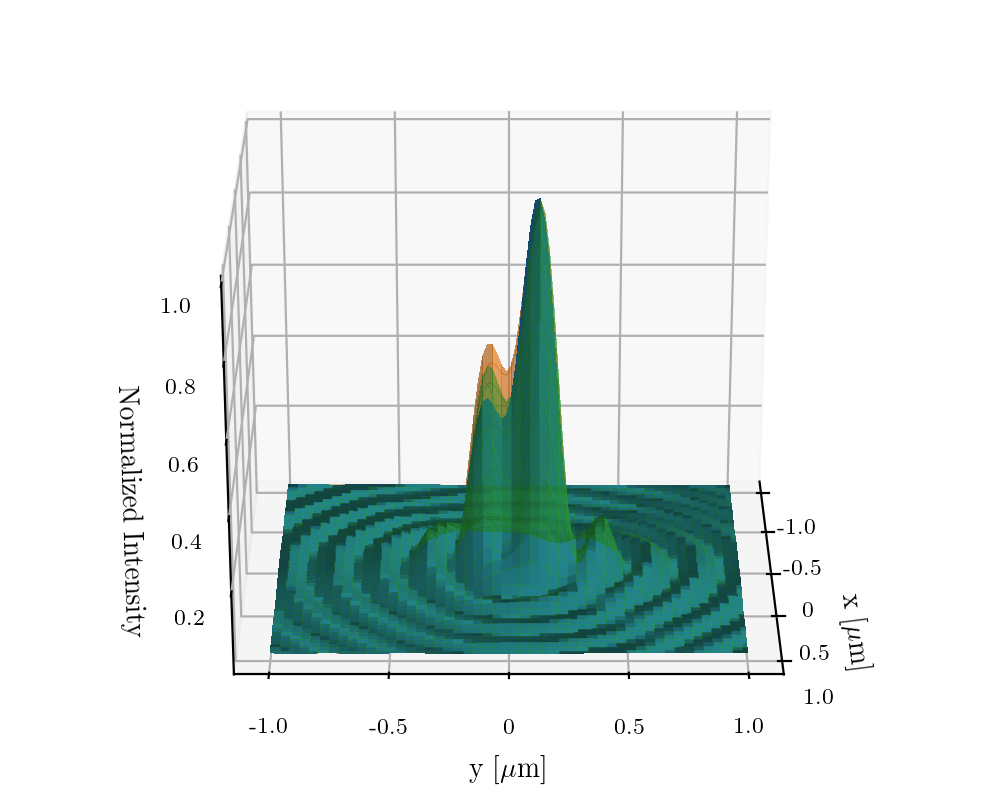

In [238]:
fig = plt.figure(figsize=(5,4))
ax = fig.gca(projection='3d')

# # Make data.
# X = np.arange(-5, 5, 0.25)
# Y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)
X = sim_inst.obs_points[1]
Y = sim_inst.obs_points[2]
Z_sim = normed_sim_img_4
Z_ana = normed_ana_img_4
Z_fit = normed_fit_img_4

# Plot the surface.
surf = ax.plot_surface(X, Y, Z_sim, #cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                      alpha=1
                      )

surf_ana = ax.plot_surface(X, Y, Z_ana, #cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                      alpha=.4
                      )
surf_ana = ax.plot_surface(X, Y, Z_fit, #cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                      alpha=.3
                      )

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'y [$\mu$m]')
ax.set_zlabel(r'Normalized Intensity')
# ax.xaxis._axinfo['label']['space_factor'] = 2.8
# ax.tick_params(axis='both', which='major', pad=5)
ax.xaxis.set_ticks([-1.0e-4, -0.5e-4, 0, 0.5e-4, 1.0e-4])
ax.xaxis.set_ticklabels(['-1.0', '-0.5', '0', ' 0.5', ' 1.0'])
ax.yaxis.set_ticks([-1.0e-4, -0.5e-4, 0, 0.5e-4, 1.0e-4])
ax.yaxis.set_ticklabels(['-1.0', '-0.5', '0', ' 0.5', ' 1.0'])
# ax.xaxis.set_major_formatter(StrMethodFormatter('{x: .1e}'))
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x: .1e}'))


# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=10)
ax.view_init(25, 0)
plt.tight_layout()
plt.show()

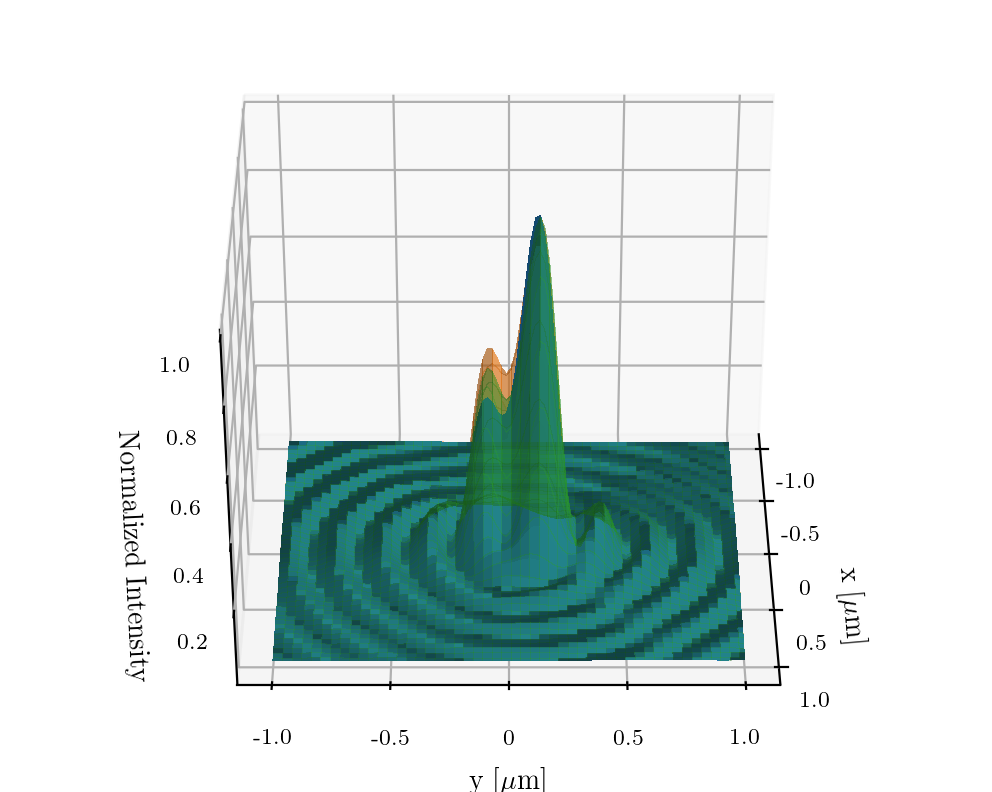

In [239]:
ax.view_init(35, 0)
fig

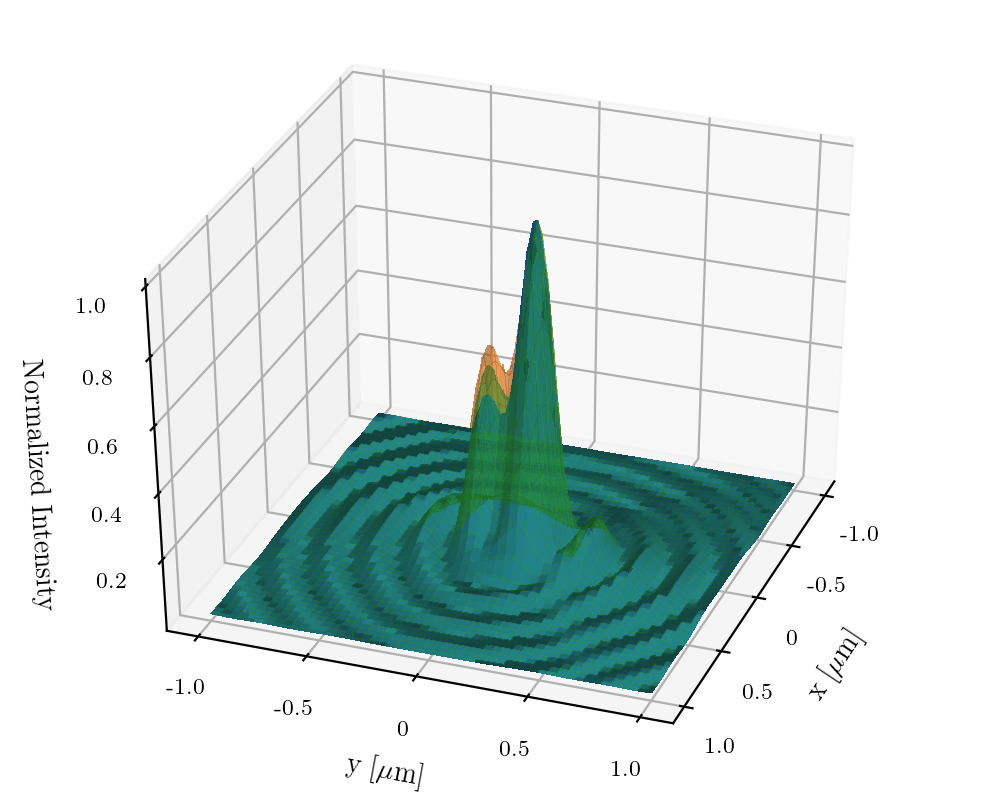

In [240]:
ax.view_init(35, 20)
fig

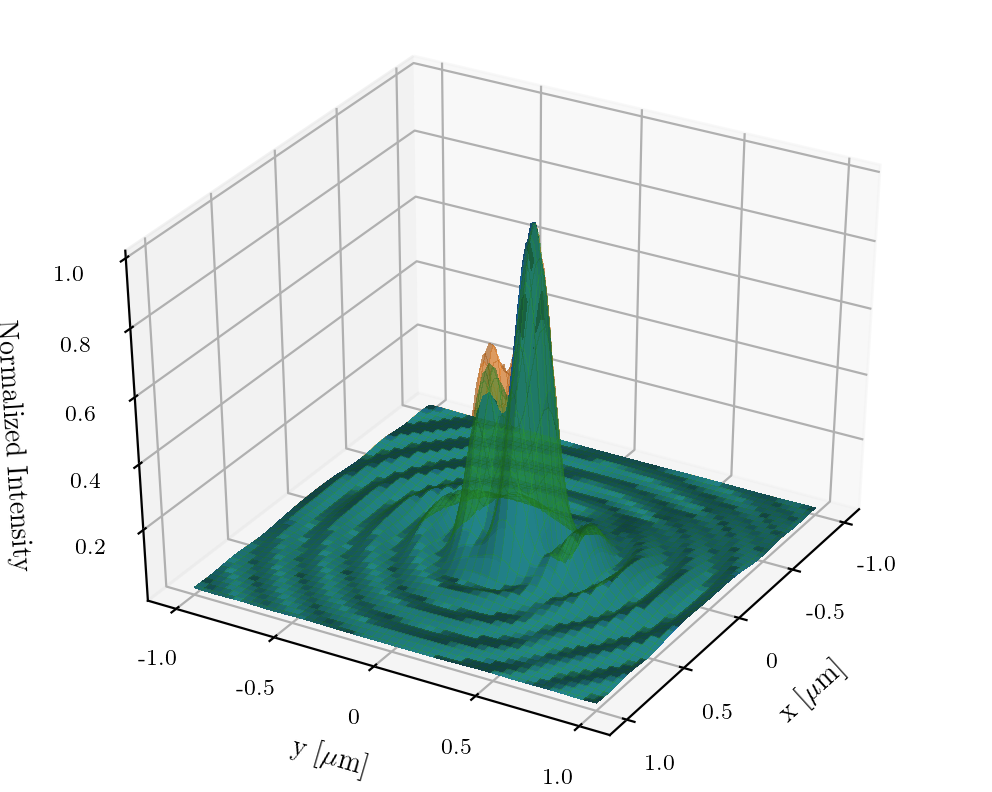

In [241]:
ax.view_init(35, 30)
fig

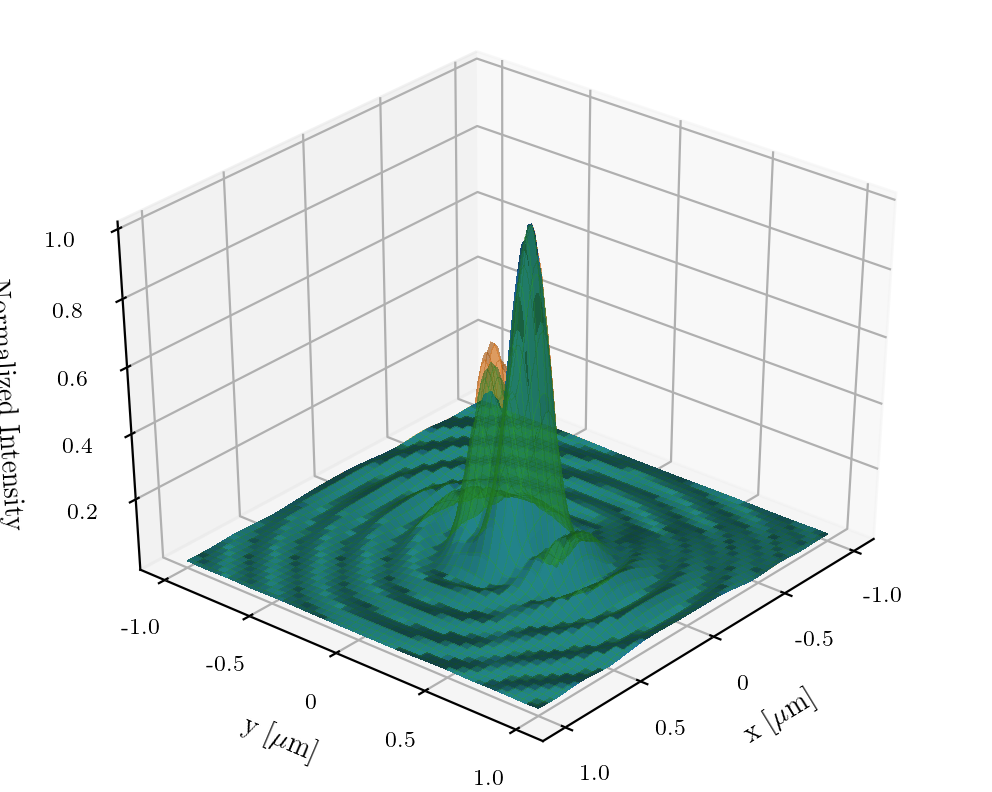

In [242]:
ax.view_init(35, 40)
fig

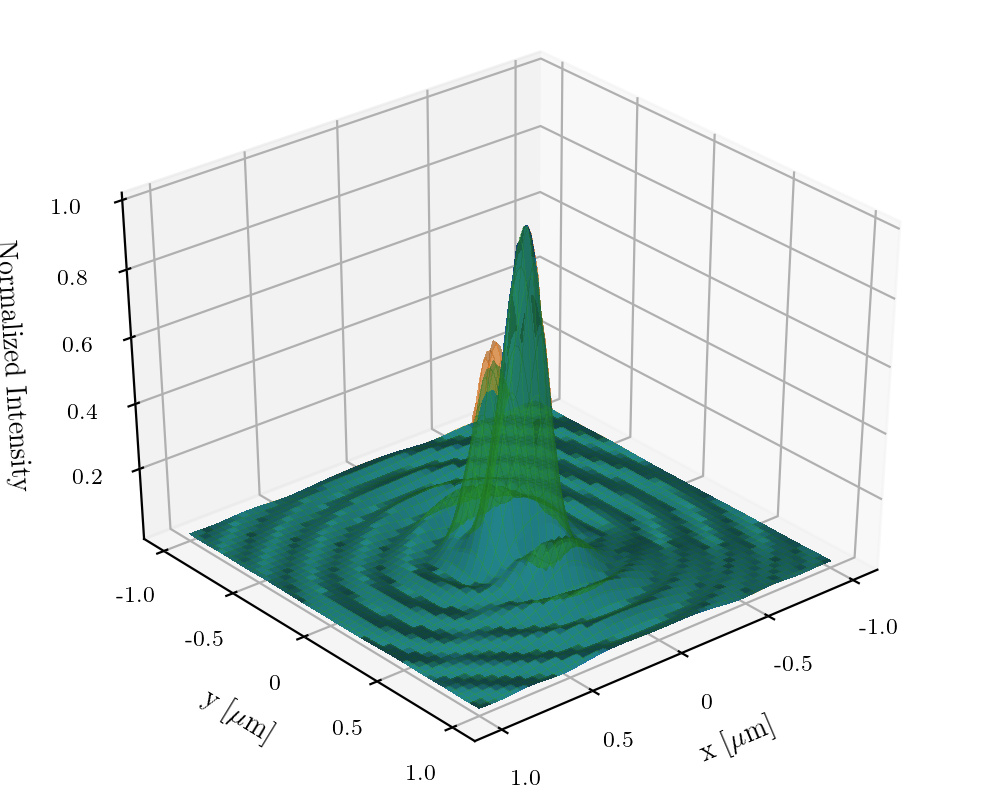

In [243]:
ax.view_init(35, 50)
fig

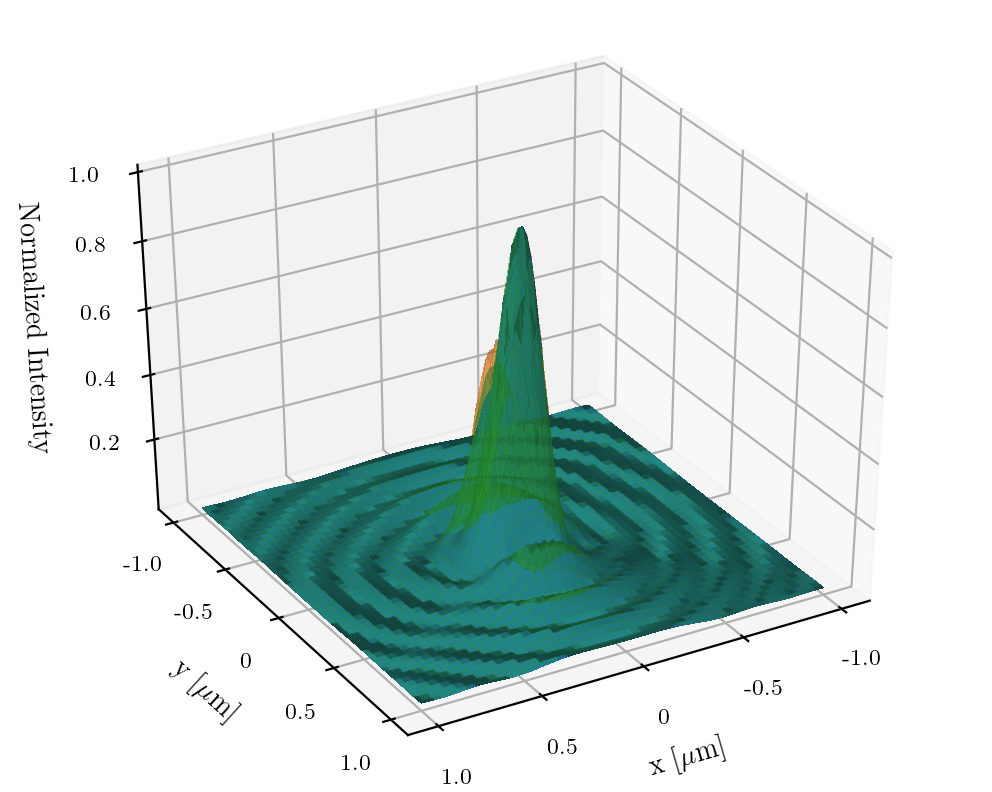

In [244]:
ax.view_init(35, 60)
fig

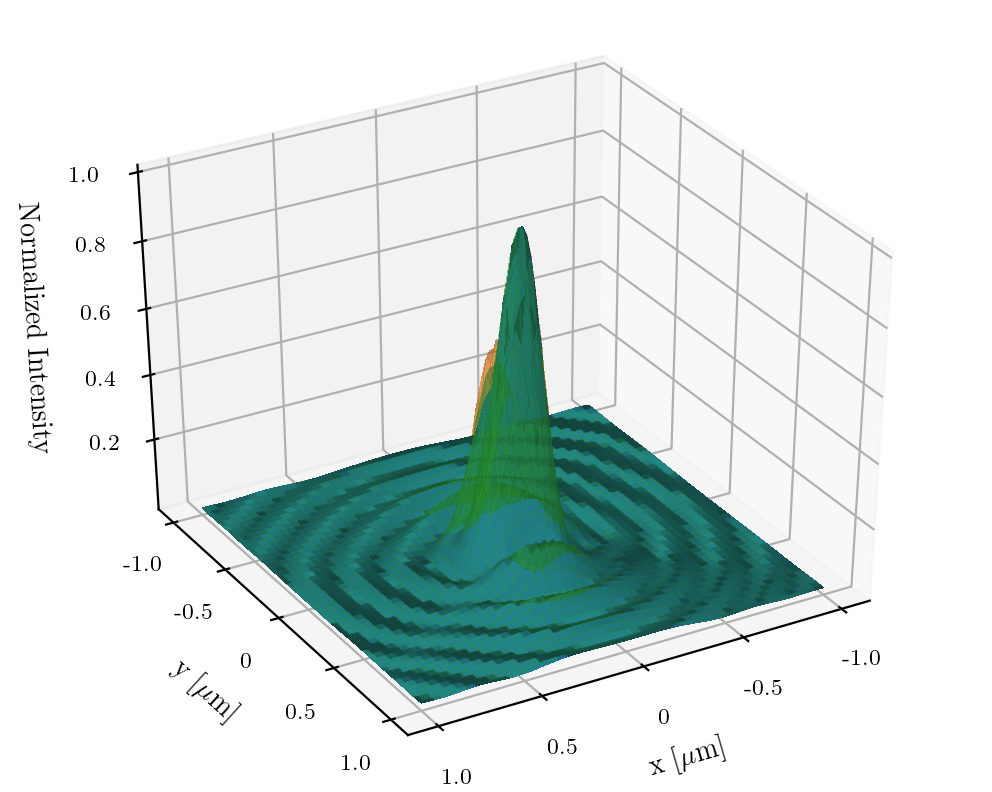

In [245]:
ax.view_init(35, 60)
fig

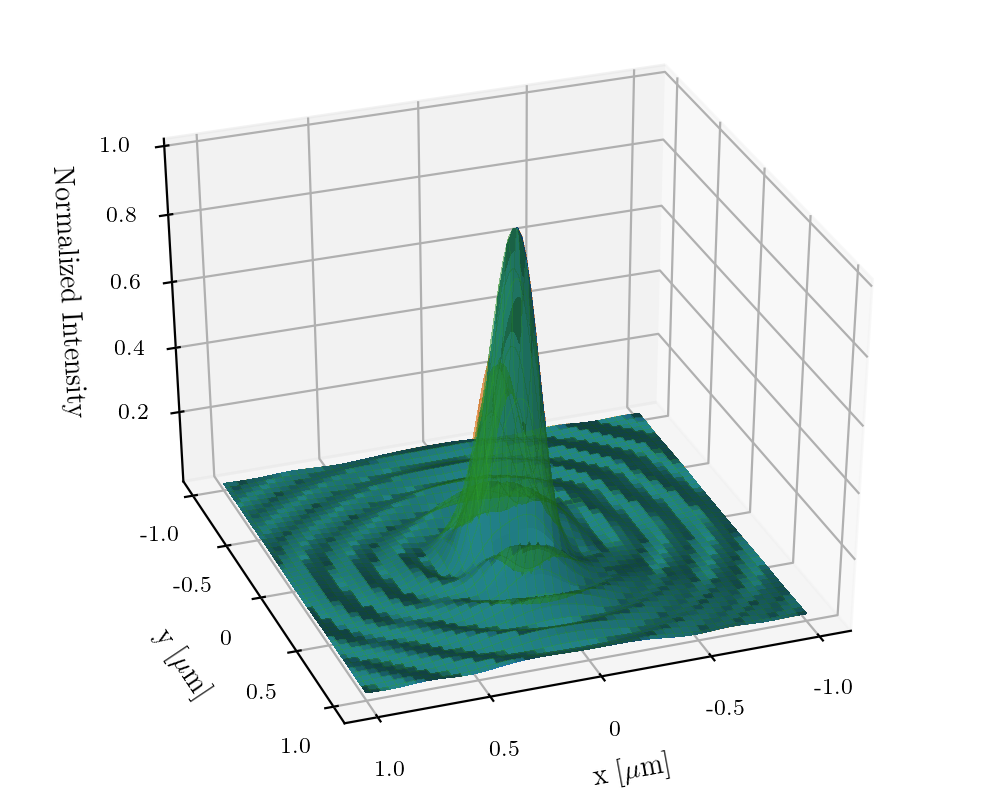

In [246]:
ax.view_init(35, 70)
fig

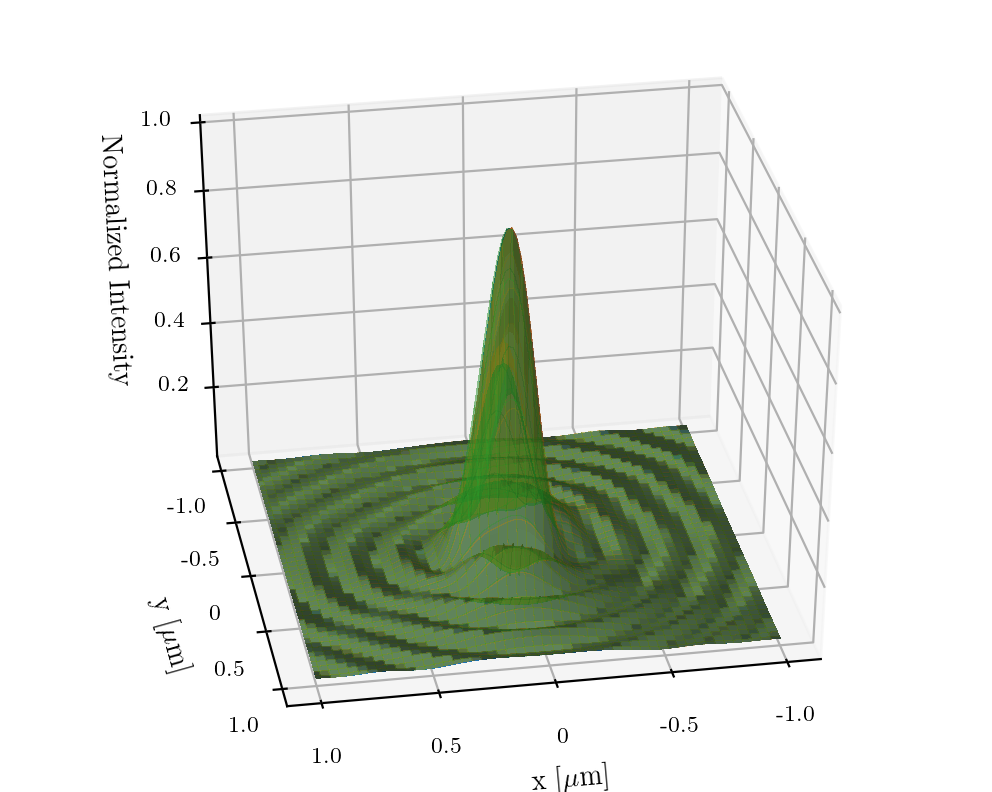

In [247]:
ax.view_init(35, 80)
fig

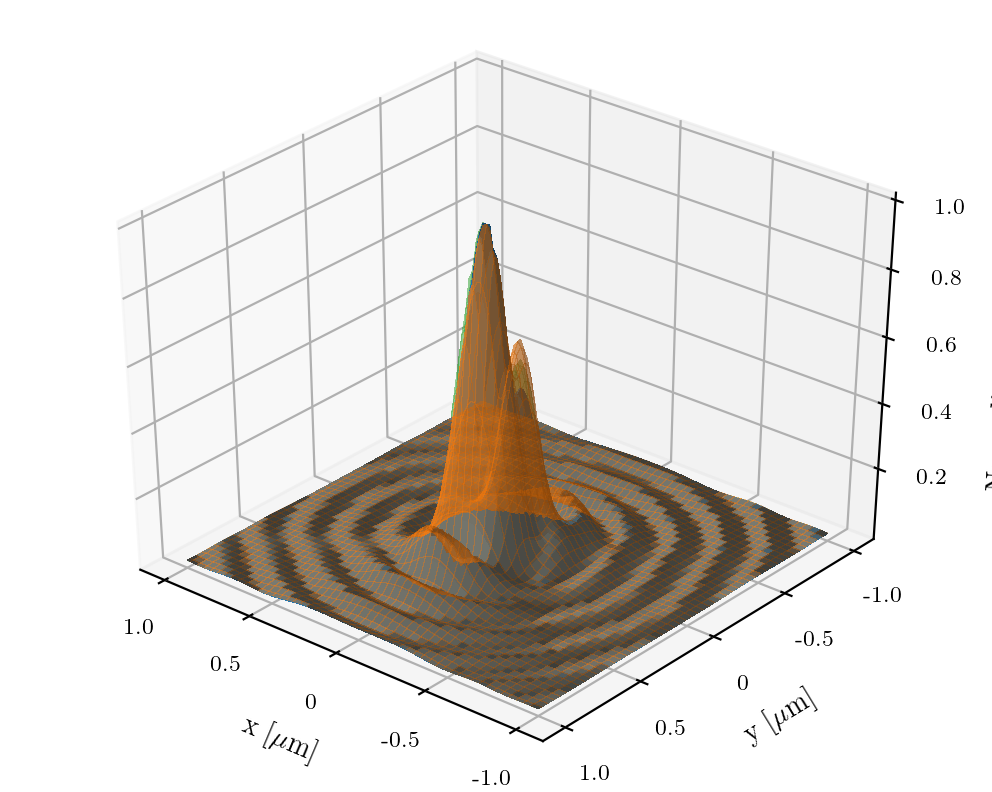

In [248]:
ax.view_init(35, 130)
fig

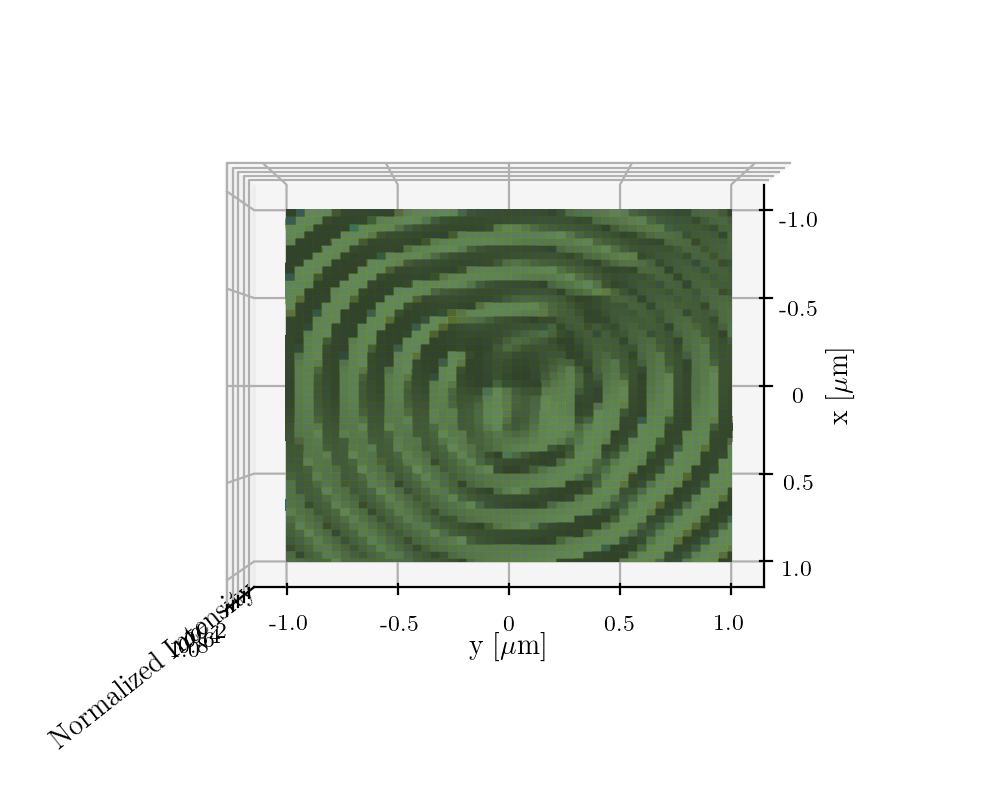

In [249]:
ax.view_init(90, 0)
fig

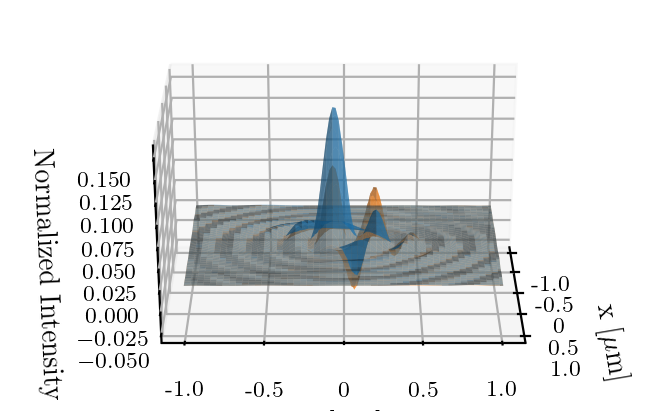

In [250]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# # Make data.
# X = np.arange(-5, 5, 0.25)
# Y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)
X = sim_inst.obs_points[1]
Y = sim_inst.obs_points[2]
Z_sim = normed_sim_img_4
Z_ana = normed_ana_img_4


# Plot the surface.
surf = ax.plot_surface(X, Y, +Z_ana-Z_sim, #cmap=cm.coolwarm,
                       linewidth=0, antialiased=True,
                      alpha=.5
                      )

surf = ax.plot_surface(X, Y, +Z_fit-Z_sim, #cmap=cm.coolwarm,
                       linewidth=0, antialiased=True,
                      alpha=.5
                      )



ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'y [$\mu$m]')
ax.set_zlabel(r'Normalized Intensity')
# ax.xaxis._axinfo['label']['space_factor'] = 2.8
# ax.tick_params(axis='both', which='major', pad=5)
ax.xaxis.set_ticks([-1.0e-4, -0.5e-4, 0, 0.5e-4, 1.0e-4])
ax.xaxis.set_ticklabels(['-1.0', '-0.5', '0', ' 0.5', ' 1.0'])
ax.yaxis.set_ticks([-1.0e-4, -0.5e-4, 0, 0.5e-4, 1.0e-4])
ax.yaxis.set_ticklabels(['-1.0', '-0.5', '0', ' 0.5', ' 1.0'])
# ax.xaxis.set_major_formatter(StrMethodFormatter('{x: .1e}'))
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x: .1e}'))


# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=10)
ax.view_init(25, 0)
plt.tight_layout()
plt.show()


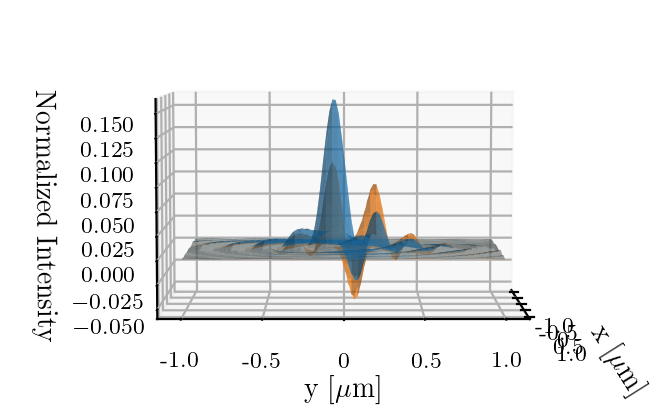

In [251]:
ax.view_init(5, 0)
fig

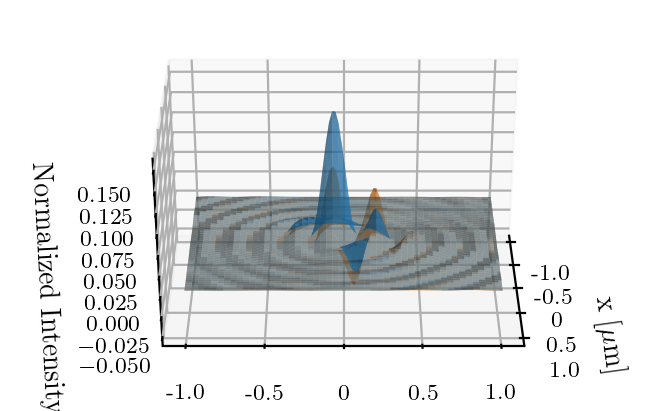

In [252]:
ax.view_init(30, 0)
fig

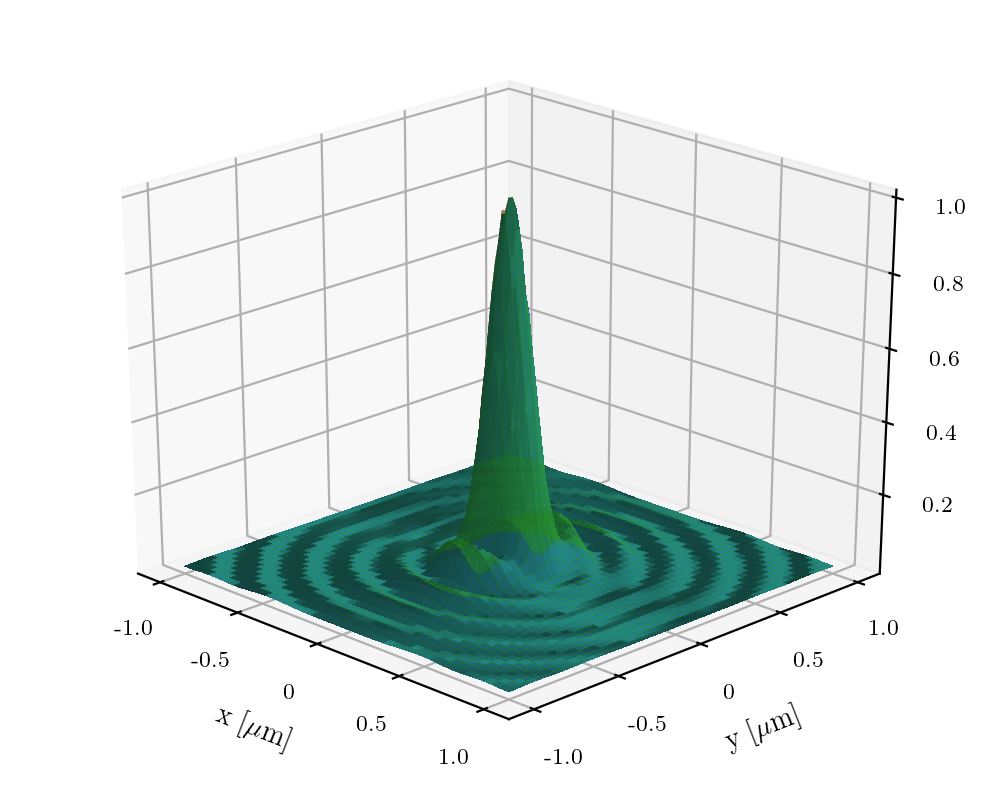

In [270]:
fig = plt.figure(figsize=(5,4))
ax = fig.gca(projection='3d')

# # Make data.
# X = np.arange(-5, 5, 0.25)
# Y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)
X = sim_inst.obs_points[1]
Y = sim_inst.obs_points[2]
Z_sim = normed_sim_img_6
Z_ana = normed_ana_img_6
Z_fit = normed_fit_img_6

# Plot the surface.
surf = ax.plot_surface(X, Y, Z_sim, #cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                      alpha=1
                      )

surf_ana = ax.plot_surface(X, Y, Z_ana, #cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                      alpha=.4
                      )
surf_ana = ax.plot_surface(X, Y, Z_fit, #cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                      alpha=.3
                      )

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'y [$\mu$m]')
ax.set_zlabel(r'Normalized Intensity')
# ax.xaxis._axinfo['label']['space_factor'] = 2.8
# ax.tick_params(axis='both', which='major', pad=5)
ax.xaxis.set_ticks([-1.0e-4, -0.5e-4, 0, 0.5e-4, 1.0e-4])
ax.xaxis.set_ticklabels(['-1.0', '-0.5', '0', ' 0.5', ' 1.0'])
ax.yaxis.set_ticks([-1.0e-4, -0.5e-4, 0, 0.5e-4, 1.0e-4])
ax.yaxis.set_ticklabels(['-1.0', '-0.5', '0', ' 0.5', ' 1.0'])
# ax.xaxis.set_major_formatter(StrMethodFormatter('{x: .1e}'))
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x: .1e}'))


# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=10)
ax.view_init(25, -45)
plt.tight_layout()
plt.show()

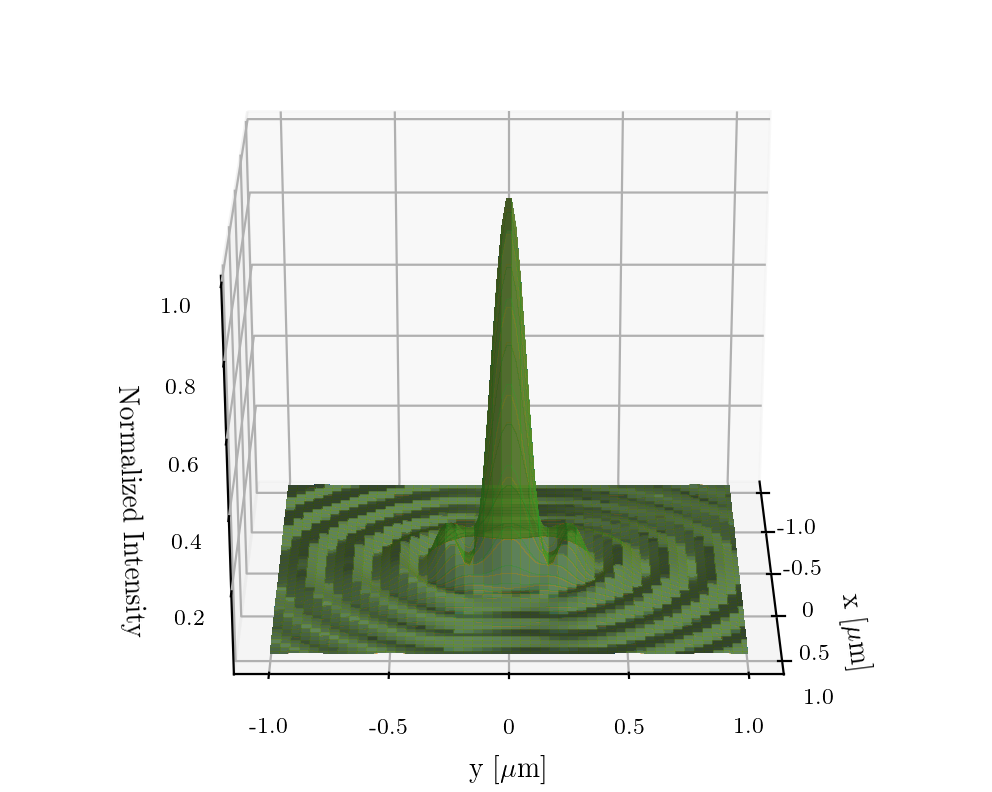

In [267]:
ax.view_init(25, -0)
fig

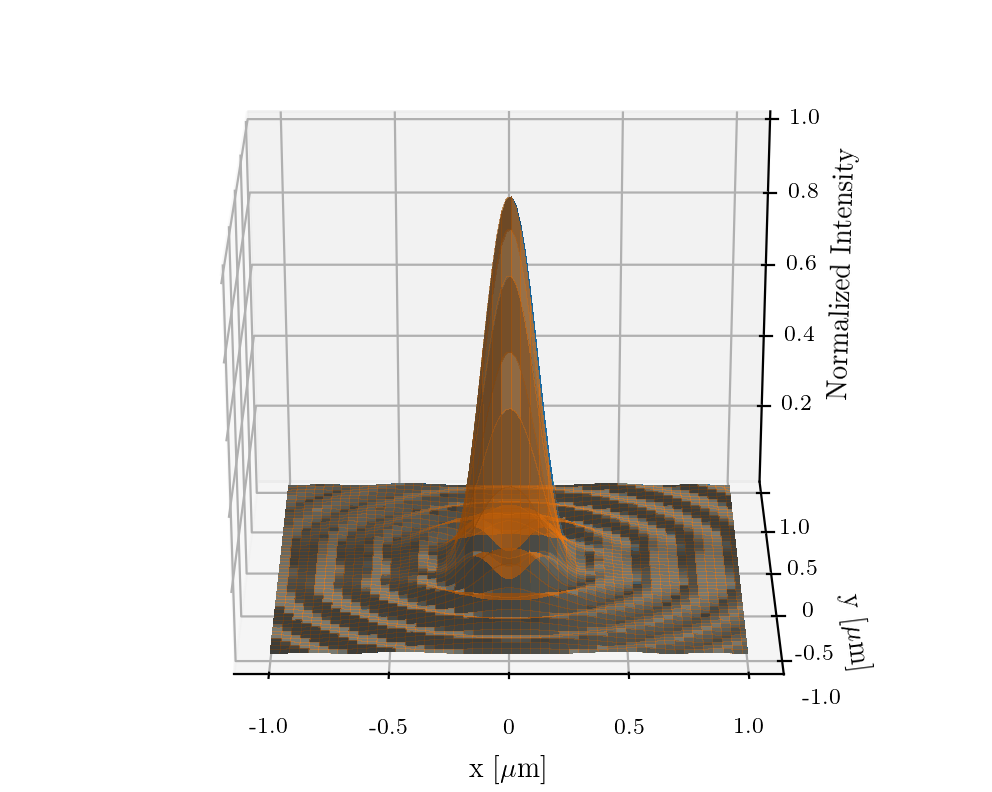

In [268]:
ax.view_init(25, -90)
fig

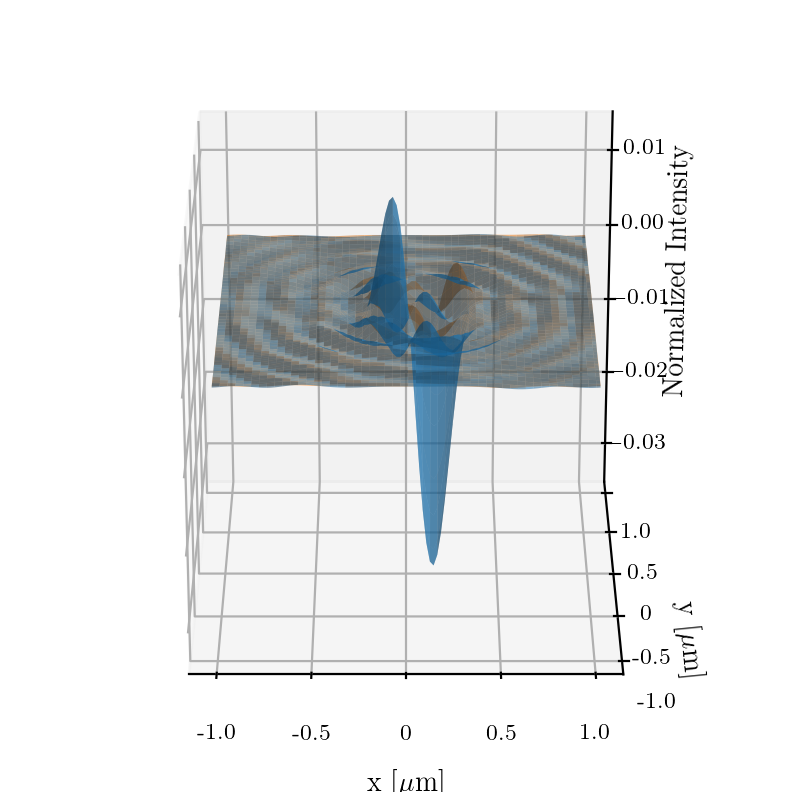

In [272]:
fig = plt.figure(figsize=(4,4))
ax = fig.gca(projection='3d')

# # Make data.
# X = np.arange(-5, 5, 0.25)
# Y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)
X = sim_inst.obs_points[1]
Y = sim_inst.obs_points[2]
Z_sim = normed_sim_img_6
Z_ana = normed_ana_img_6
Z_fit = normed_fit_img_6


# Plot the surface.
surf = ax.plot_surface(X, Y, +Z_ana-Z_sim, #cmap=cm.coolwarm,
                       linewidth=0, antialiased=True,
                      alpha=.5
                      )

surf = ax.plot_surface(X, Y, +Z_fit-Z_sim, #cmap=cm.coolwarm,
                       linewidth=0, antialiased=True,
                      alpha=.5
                      )



ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'y [$\mu$m]')
ax.set_zlabel(r'Normalized Intensity')
# ax.tick_params(axis='z', which='major', pad=15)
# ax.xaxis._axinfo['label']['space_factor'] = 2.8
# ax.tick_params(axis='both', which='major', pad=5)
ax.xaxis.set_ticks([-1.0e-4, -0.5e-4, 0, 0.5e-4, 1.0e-4])
ax.xaxis.set_ticklabels(['-1.0', '-0.5', '0', ' 0.5', ' 1.0'])
ax.yaxis.set_ticks([-1.0e-4, -0.5e-4, 0, 0.5e-4, 1.0e-4])
ax.yaxis.set_ticklabels(['-1.0', '-0.5', '0', ' 0.5', ' 1.0'])
# ax.xaxis.set_major_formatter(StrMethodFormatter('{x: .1e}'))
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x: .1e}'))


# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=10)
ax.view_init(25, -90)
plt.tight_layout()
plt.show()

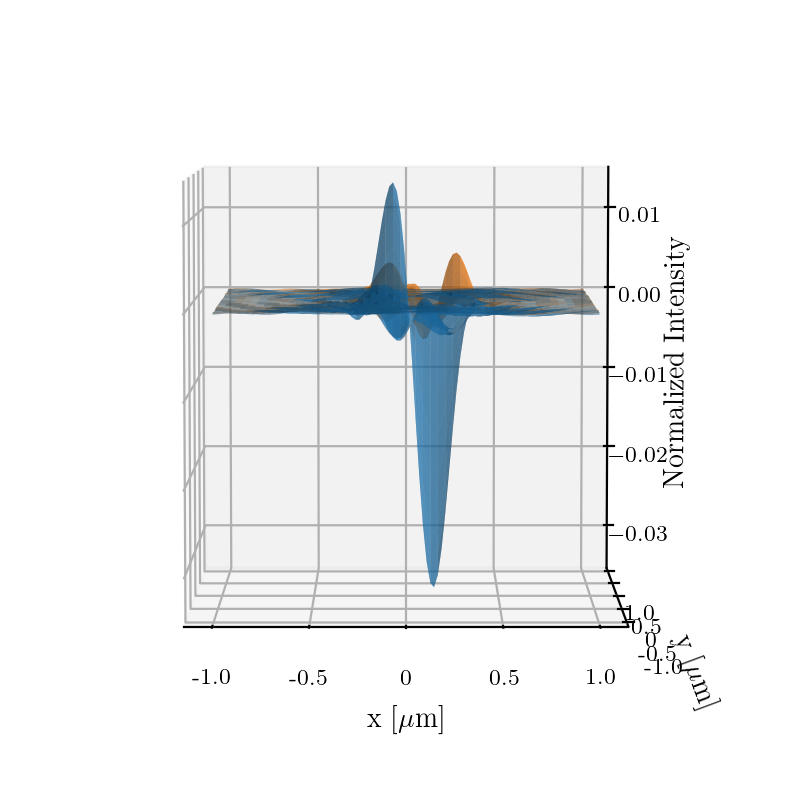

In [262]:
ax.view_init(5, -90)
fig